# Cloudbow analysis


This notebook analyses the effect cloudbow properties and the relation to the microphysical properties of the medium. 

---

Relevant papers:
- François‐Marie Bréon  Philippe Goloub, "Cloud droplet effective radius from spaceborne polarization measurements", 1998. https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/98GL01221
- F.M. Breon, M. Doutriaux-Boucher, "A comparison of cloud droplet radii measured from space", 2005. https://ieeexplore.ieee.org/document/1487637

In [1]:
"""
Imports necessary for this notebook
"""
import os 
import matplotlib.pyplot as plt
import numpy as np
import shdom

In [2]:
"""
Function definitions necessary for this notebook
"""
def load_mie(wavelength, veff):
    directory = '../mie_tables/veff_{:.3f}'.format(veff)
    filename = 'Water_{:d}nm_pol.scat'.format(int(wavelength*1000))
    input_path = os.path.join(directory, filename)
    mie = shdom.MiePolarized()
    mie.read_table(input_path)
    return mie 

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def get_atmosphere(csv_path, wavelength, veff):
    
    # Mie scattering for water droplets
    mie = load_mie(wavelength, veff)

    # icrophysical medium
    microphysics = shdom.MicrophysicalMedium()
    microphysics.load_from_csv(csv_path)

    # Rayleigh scattering for air molecules
    temperatures = np.array([283.64, 283.41, 283.17, 282.94, 282.72, 282.50, 282.29, 282.11, 
                             281.95, 281.82, 281.69, 281.58, 281.50, 281.71, 283.87, 286.190])
    temp_grid = shdom.Grid(z=microphysics.grid.z)
    temperature_profile = shdom.GridData(temp_grid, temperatures)
    rayleigh = shdom.RayleighPolarized(wavelength)
    rayleigh.init_temperature_profile(temperature_profile)

    cloud = shdom.Medium()
    air = shdom.AmbientMedium()

    extinction_c, albedo_c, phase_c = mie.interpolate_scattering_field(microphysics.lwc, microphysics.reff, phase_type='Tabulated')
    extinction_a, albedo_a, phase_a = rayleigh.get_scattering_field(temp_grid, phase_type='Tabulated')

    cloud.set_optical_properties(extinction_c, albedo_c, phase_c)
    air.set_optical_properties(extinction_a, albedo_a, phase_a)

    atmosphere = cloud + air
    
    return atmosphere

def stokes_to_rgb(img):
    img = (img - img.min()) / (img.max() - img.min())
    return np.flip(img, axis=0).transpose([1, 2, 0])

## Mie scattering

In [34]:
"""
Load Mie tables. To generate new mie tables see:
    scripts/generate_polarized_mie_tables.py
"""

veffs = [0.01, 0.02, 0.05, 0.1]
wavelengths = [0.442, 0.67, 0.865]
mie_tables = []

for veff in veffs:
    mie_tables.append([load_mie(wavelen, veff) for wavelen in wavelengths])
 
reffs = mie_tables[0][0].reff

Reading mie table from file: ../mie_tables/veff_0.010/Water_442nm_pol.scat
Done.
Reading mie table from file: ../mie_tables/veff_0.010/Water_670nm_pol.scat
Done.
Reading mie table from file: ../mie_tables/veff_0.010/Water_865nm_pol.scat
Done.
Reading mie table from file: ../mie_tables/veff_0.020/Water_442nm_pol.scat
Done.
Reading mie table from file: ../mie_tables/veff_0.020/Water_670nm_pol.scat
Done.
Reading mie table from file: ../mie_tables/veff_0.020/Water_865nm_pol.scat
Done.
Reading mie table from file: ../mie_tables/veff_0.050/Water_442nm_pol.scat
Done.
Reading mie table from file: ../mie_tables/veff_0.050/Water_670nm_pol.scat
Done.
Reading mie table from file: ../mie_tables/veff_0.050/Water_865nm_pol.scat
Done.
Reading mie table from file: ../mie_tables/veff_0.100/Water_442nm_pol.scat
Done.
Reading mie table from file: ../mie_tables/veff_0.100/Water_670nm_pol.scat
Done.
Reading mie table from file: ../mie_tables/veff_0.100/Water_865nm_pol.scat
Done.


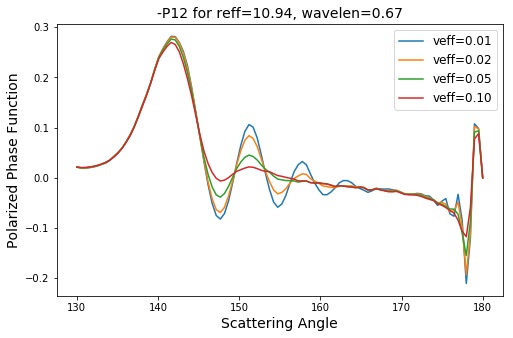

In [35]:
"""
Plot polarized phase function for different wavelengths effective variances
"""
re_index = find_nearest(reffs, 11.0)
wavelen_index = find_nearest(wavelengths, 0.67)

angles = np.linspace(130, 180, 100)

%matplotlib inline
plt.figure(figsize=(8,5))
for i, veff in enumerate(veffs):
    phase = -mie_tables[i][wavelen_index].transform_wignerd_to_phase(re_index, 5, angles)
    plt.plot(angles, phase, label='veff={:.2f}'.format(veff))
    plt.title('-P12 for reff={:.2f}, wavelen={:.2f}'.format(reffs[re_index], wavelengths[wavelen_index]), fontsize=14)
    plt.legend(fontsize=12)
    plt.xlabel('Scattering Angle', fontsize=14)
    plt.ylabel('Polarized Phase Function', fontsize=14)

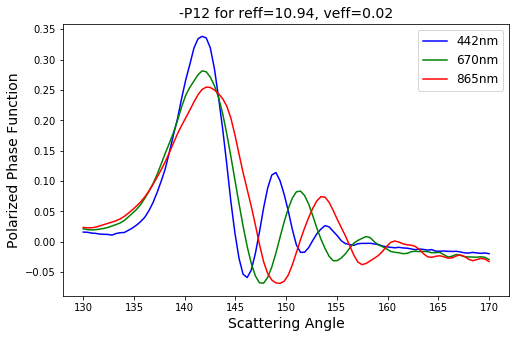

In [41]:
"""
Plot polarized phase function for different wavelengths
"""
re_index = find_nearest(reffs, 11.0)
ve_index = find_nearest(veffs, 0.02)

angles = np.linspace(130, 170, 100)

%matplotlib inline
colors = ['b', 'g', 'r']
plt.figure(figsize=(8,5))
for j, wavelen in enumerate(wavelengths):
    phase = -mie_tables[ve_index][j].transform_wignerd_to_phase(re_index, 5, angles)
    plt.plot(angles, phase, label='{}nm'.format(int(wavelen*1000)), color=colors[j])
    plt.title('-P12 for reff={:.2f}, veff={:.2f}'.format(reffs[re_index], veffs[ve_index]), fontsize=14)
    plt.legend(fontsize=12)
    plt.xlabel('Scattering Angle', fontsize=14)
    plt.ylabel('Polarized Phase Function', fontsize=14)

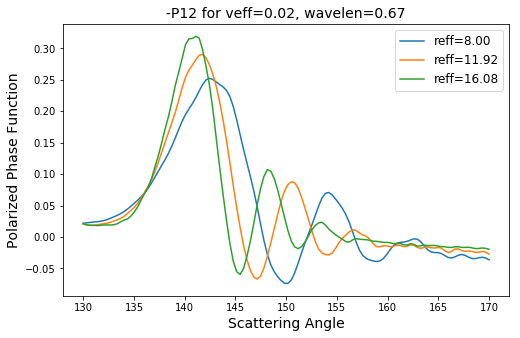

In [45]:
"""
Plot polarized phase function for different wavelengths effective radii
"""

ve_index = find_nearest(veffs, 0.02)
re_indices = [find_nearest(reffs, reff) for reff in [8.0, 12.0, 16.0]]
wavelen_index = find_nearest(wavelengths, 0.67)

angles = np.linspace(130, 170, 100)

%matplotlib inline
plt.figure(figsize=(8,5))
for re_index in re_indices:
    phase = -mie_tables[ve_index][wavelen_index].transform_wignerd_to_phase(re_index, 5, angles)
    plt.plot(angles, phase, label='reff={:.2f}'.format(reffs[re_index]))
    plt.title('-P12 for veff={:.2f}, wavelen={:.2f}'.format(veffs[ve_index], wavelengths[wavelen_index]), fontsize=14)
    plt.legend(fontsize=12)
    plt.xlabel('Scattering Angle', fontsize=14)
    plt.ylabel('Polarized Phase Function', fontsize=14)

## Stcu cloudbow

In [3]:
"""
Load a Stratocumulus cloud field from SHDOM original distribution.
The atmosphere containts both Rayleigh and Mie scattering.
"""

csv_path = '../synthetic_cloud_fields/shdom/les_stcu.txt'
wavelengths = [0.442, 0.67, 0.865]
veff=0.1

atmospheres = [get_atmosphere(csv_path, wavelen, veff) for wavelen in wavelengths]

Reading mie table from file: ../mie_tables/veff_0.100/Water_442nm_pol.scat
Done.
Reading mie table from file: ../mie_tables/veff_0.100/Water_670nm_pol.scat
Done.
Reading mie table from file: ../mie_tables/veff_0.100/Water_865nm_pol.scat
Done.


In [4]:
numerical_params = shdom.NumericalParameters()
scene_params = shdom.SceneParameters(
        source=shdom.SolarSource(azimuth=0, zenith=180),
        boundary_conditions={'y': shdom.BoundaryCondition.periodic, 
                             'x': shdom.BoundaryCondition.periodic},
    )   

rte_solvers = shdom.RteSolverArray()
for atmosphere, wavelength in zip(atmospheres, wavelengths):
    scene_params.wavelength = wavelength
    rte_solver = shdom.RteSolverPolarized(3, scene_params, numerical_params)
    rte_solver.init_medium(atmosphere)
    rte_solvers.add_solver(rte_solver, name='{} micron'.format(wavelength))

rte_solvers.solve(maxiter=100)   

In [7]:
"""
Define a camera projection model and render the stokes componenets
A cloudbow is simulated using a perspective camera
"""
projection = shdom.PerspectiveProjection(fov=100, nx=1000, ny=1000, x=1.75, y=1.75, z=10.0)
projection.look_at_transform(point=[1.75, 1.75, 0.0], up=[1.0, 0.0, 0.0])
camera = shdom.Camera(shdom.PolarizationSensor(), projection)

stokes = []
for rte_solver in rte_solvers.solver_list:
    stokes.append(camera.render(rte_solver)[0])
    
stokes = np.array(stokes)

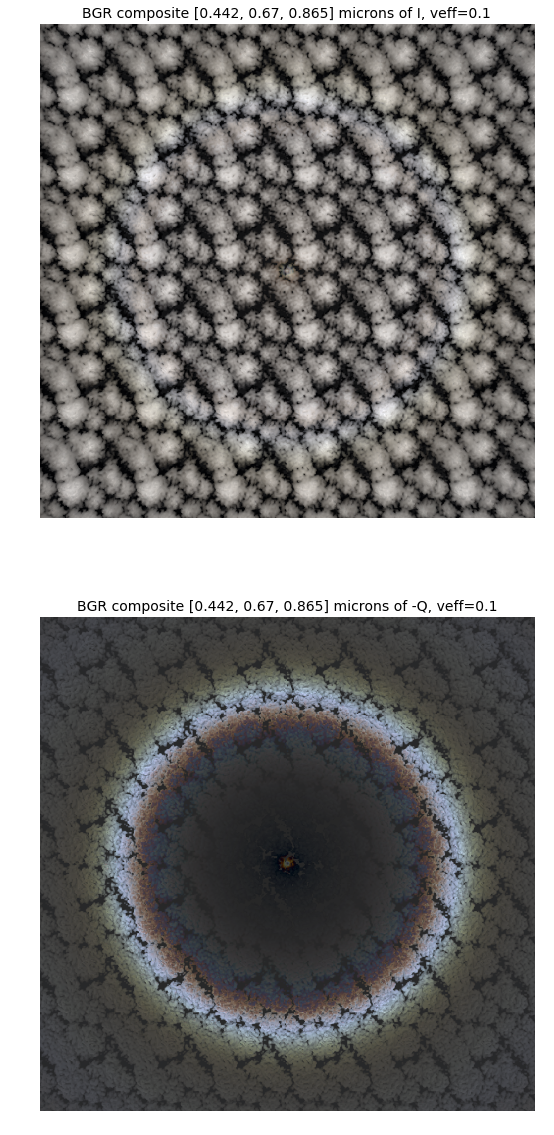

In [110]:
"""
Plot a composite RGB image for I, Q of the stokes vector
""" 
stokes_i = stokes_to_rgb(stokes[:,0])
stokes_q = stokes_to_rgb(-stokes[:,1])

%matplotlib inline

fig, axes = plt.subplots(2, 1, figsize=(10, 20))
axes[0].imshow(stokes_i)
axes[0].set_axis_off();
axes[0].set_title('BGR composite [{}, {}, {}] microns of I, '\
                  'veff={}'.format(*(wavelengths + [veff])), fontsize=14)

axes[1].imshow(stokes_q)
axes[1].set_axis_off();
axes[1].set_title('BGR composite [{}, {}, {}] microns of -Q, ' \
                  'veff={}'.format(*(wavelengths + [veff])), fontsize=14)

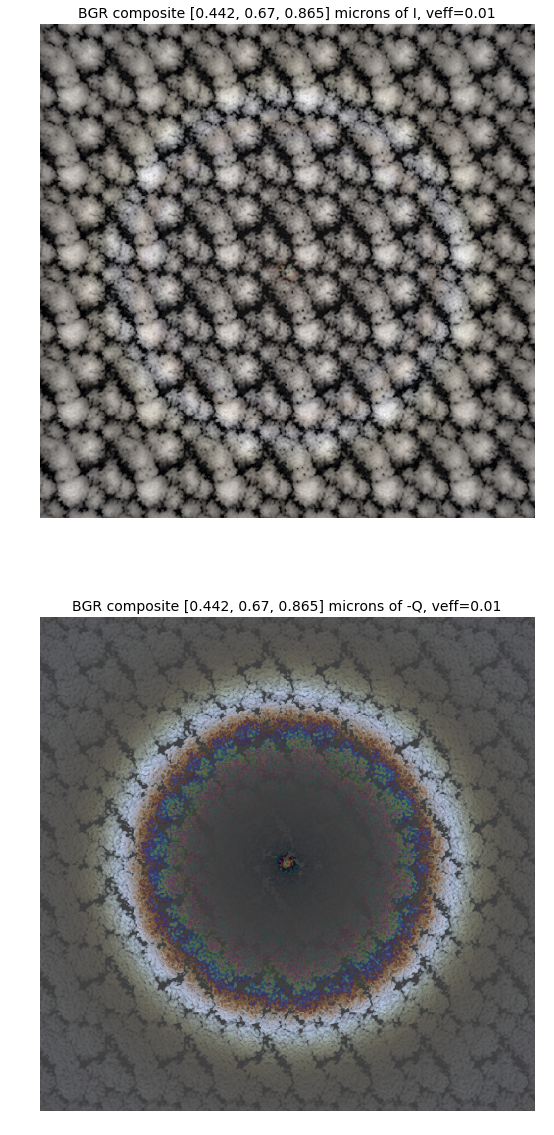

In [107]:
"""
Plot a composite RGB image for I, Q of the stokes vector
""" 
stokes_i = stokes_to_rgb(stokes[:,0])
stokes_q = stokes_to_rgb(-stokes[:,1])

%matplotlib inline

fig, axes = plt.subplots(2, 1, figsize=(10, 20))
axes[0].imshow(stokes_i)
axes[0].set_axis_off();
axes[0].set_title('BGR composite [{}, {}, {}] microns of I, '\
                  'veff={}'.format(*(wavelengths + [veff])), fontsize=14)

axes[1].imshow(stokes_q)
axes[1].set_axis_off();
axes[1].set_title('BGR composite [{}, {}, {}] microns of -Q, ' \
                  'veff={}'.format(*(wavelengths + [veff])), fontsize=14)